1不純物アンダーソンモデルの不純物に対するグリーン関数は
 
$$G_f(i\omega_n)=\frac{1}{i\omega_n-E_f-\Sigma_f(i\omega_n)-\Delta(i\omega_n)}$$
 
$\Delta(i\omega_n)$は、着目している不純物とそのまわりとの混成の寄与を表す。  
分母から自己エネルギーを除いた
 
$$\begin{eqnarray}
g(i\omega_n) &\equiv& \frac{1}{i\omega_n-E_f-\Delta(i\omega_n)}
&=& \frac{1}{1/G(i\omega_n)+\Sigma_f(i\omega_n)}
\tag{1}
\end{eqnarray}$$
 
を定義する。
 ※$g(i\omega_n)$には混成の寄与が入っているので、自由粒子のグリーン関数ではない。
 
元の格子系のグリーン関数
 
$$G(k,i\omega_n)=\frac{1}{i\omega_n-\epsilon_k-\Sigma(k,i\omega_n)}$$

について、
 
$$\begin{equation}
\tag{2}
\Sigma(k,i\omega_n) \sim \Sigma_f(i\omega_n)
\end{equation}$$
 
と考えて（⇒波数依存性を無視している）
 
$$G(k,i\omega_n)=\frac{1}{i\omega_n-\epsilon_k-\Sigma_f(i\omega_n)}$$
とする。  
そして、1サイトグリーン関数は
 
$$\begin{eqnarray}
G_i(i\omega_n) &=& <G(k,i\omega_n)>_k
&=& \int_{-\infty}^{\infty}d\epsilon\rho(\epsilon)G(k,i\omega_n) 
\tag{3}
\end{eqnarray}$$
 
で求まる。$<\sim>_k$は波数についての平均。$\rho(\epsilon)$は状態密度。  
この1サイトグリーン関数が先ほどの不純物のグリーン関数に等しいと考える。
 
$$G_f(i\omega_n) \sim G_i(i\omega_n)$$
 
ゆえに(1)式より$g(i\omega_n)$が求まる。  
不純物ソルバーによってこの$g(i\omega_n)$から新たに不純物の自由エネルギー$\Sigma_f^{(new)}(i\omega_n)$を求め、この新しい$\Sigma_f^{(new)}(i\omega_n)$を用いて再度(2)式から同じことを繰り返すことができる。  
 
以上の自己無撞着計算を行う。
ただし、状態密度は半径2の半円とする。
$$\rho(\epsilon) = \frac{1}{2\pi}\sqrt{4-\epsilon^2}$$
また。不純物ソルバーとしてIPTを採用し、$g(i\omega_n)$から$\Sigma_f^{(new)}(i\omega_n)$は、
$$\begin{equation}
\tag{4}
\Sigma_f^{(new)}(\tau) = U^{2}g(\tau)^{2}g(\beta-\tau)
\end{equation}$$
で求める。$\tau$表示での関係なのでフーリエ変換を行う必要がある。

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

roop : 90


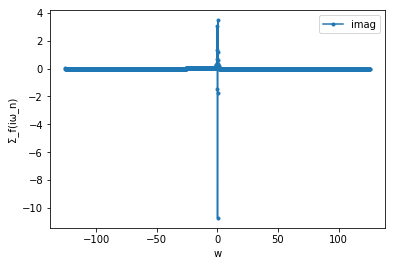

In [4]:
n_tau = 1000
beta = 50
tau = np.linspace(0, beta, n_tau)
n_w = np.arange(-1000,1001)
w = np.pi*(2*n_w+1)/beta

#自己無撞着計算の1回分の計算を行う関数を定義

def S_iw_new(beta,S_iw,U):
    '''
    S_iw_new(beta,S_iw,U)
    beta:逆温度,  S_iw:自己エネルギーΣ_f(iω_n),  U:相互作用の大きさ
    
    '''
    
    #(3)式の積分計算を2重指数関数型積分で行う。
    
    h = 1/200                  #刻み幅
    i = np.arange(-1000,1001)  #和の打ち切り範囲
    G_matrix = 1/(np.fromfunction(lambda n,j:1j*w[n-1]-2*np.tanh(np.pi/2*np.sinh(i[j-1]*h)), \
                                  (len(w),len(i)),dtype = int) - S_iw)
    w_vector=np.cosh(i*h)/((np.cosh(np.pi/2*np.sinh(i*h)))**3)
    G_iw = h*np.dot(G_matrix,w_vector)
    
    assert G_iw.shape == (len(w),)
    
    g_iw = 1/(1/G_iw + S_iw)
    
    assert g_iw.shape == (len(w),)
    
    #フーリエ級数をとってτ表示へ
    
    exp_matrix = np.fromfunction(lambda n,t : np.exp(-1j*w[n-1]*tau[t-1]), (len(w), n_tau),dtype=int )
    g_tau = (1/beta)*np.dot(g_iw-1/(1j*w), exp_matrix) - 1/2
    
    assert g_tau.shape == (n_tau,)
    
    #(4)式によりΣ_f(τ)を導く。
    
    S_tau = (U**2)*(g_tau**2)*(g_tau[::-1])
    
    #Σ(τ)を3次スプライン補間
    
    S_tau_func = interp1d(tau, S_tau, kind='cubic')
    
    #Σ(τ)を（台形則による）フーリエ変換でΣ_f(iω_n)へ
    
    N = 10000 #分割数
    tau_new = np.linspace(0, beta, N)
    exp_matrix = np.fromfunction(lambda n,t : np.exp(1j*w[n-1]*tau_new[t-1]), (len(w), N),dtype=int )
    S_iw_new = (beta/N)*np.dot(exp_matrix, S_tau_func(tau_new)+1/2) + 1/(1j*w)
    
    assert S_iw_new.shape == (len(w),)
    
    return S_iw_new
    
    

#自己無撞着計算をする関数を定義。

def recur(beta,U,k=0) :
    '''
    recur(beta,U,k=0)
    beta:逆温度,  U:相互作用,  k:混ざり具合(0≦k≦1)
    
    '''
    
    #Σ_f(iω_n)をゼロに初期化。
    
    S_iw = np.zeros_like(w)
    
    for i in range(100) :  #ループ回数の上限を100回とする。
        
        S_iw_next = (1-k)*S_iw_new(beta,S_iw,U) + k*S_iw
        
        #すべての要素の誤差が閾値以下ならループを抜け出す。
        
        if np.all(abs( (S_iw_next-S_iw).imag/max(S_iw_next) ) ) < 0.001 :
            print('roop :',i+1)
            return S_iw_next
            break
        
        S_iw = S_iw_next
        
    else :
        print('roop :',100)
       
        
S_iw_U1 = recur(beta=50,U=1)

plt.plot(w, S_iw_U1.imag, label='imag', marker='.')
plt.xlabel('w')
plt.ylabel('Σ_f(iω_n)')
plt.legend()
plt.show()

In [ ]:
S_iw_matrix = S_iw_U1

# U=2からU=6の場合も計算

for u in range(2,6) :
    S_iw_matrix = np.vstack(S_iw_U , recur(beta=50,U=u))

# U=10の場合も計算

S_iw_U = np.vstack(S_iw_matrix,recur(beta=50,U=10))

plt.plot(w, S_iw_U.imag[0,:], label='U=1', marker='.')
plt.plot(w, S_iw_U.imag[1,:], label='U=2', marker='.')
plt.plot(w, S_iw_U.imag[2,:], label='U=3', marker='.')
plt.plot(w, S_iw_U.imag[3,:], label='U=4', marker='.')
plt.plot(w, S_iw_U.imag[4,:], label='U=5', marker='.')
plt.plot(w, S_iw_U.imag[5,:], label='U=6', marker='.')
plt.plot(w, S_iw_U.imag[6,:], label='U=10', marker='.')
plt.xlabel('w')
plt.ylabel('Σ_f(iω_n)')
plt.legend()
plt.show()

In [ ]:
U = np.array([0,1,2,3,4,5,6,10])
w_0 = np.pi/beta
z = 1/(1 - S_iw_matrix[:,1000:1001].imag/w_0)
print(w_0)
print(z)
plt.plot(U,z,marker=".")
plt.ylim([0,1.5]) 
plt.xlabel("U")
plt.ylabel("z")
plt.show()